['Date', 'UK', 'Japan', 'Korea', 'South Africa', 'Germany', 'Australia ', 'Canada', 'Sweden', 'France', 'Italy', 'Iceland', 'Norway', 'Denmark', 'New Zealand', 'Israel', 'Belgium', 'Austria', 'Finland ']
19


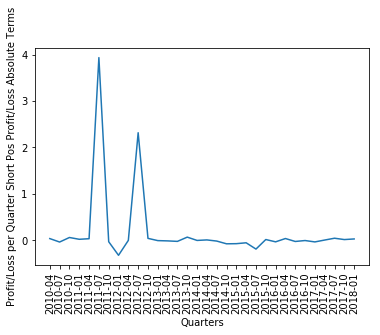

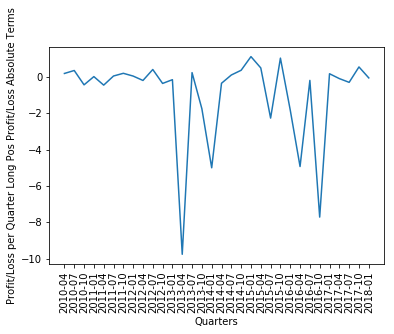

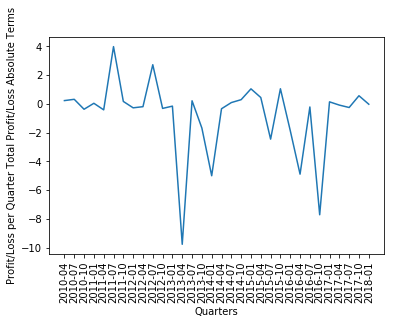

In [5]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt

#reading the excel data to create final pandas dataframe column
def finalDFColumnName(df):
    countries = list(df.columns.values)
    pickElem = np.arange(7, len(countries), 5)
    dfColumn = ['Date', 'UK']
    for i in range(len(pickElem)):
        dfColumn.append(countries[pickElem[i]])
    return dfColumn

#function for current account scoring
def currentAccountScore(value):
    sign = value/abs(value)
    score = (abs(value) - 1) * 4 * sign * 2
    return score

#function for Real Rate scoring
def realRateScore(value):
    siVal = value - 3
    score = siVal * 4 * 2
    return score

#function for Real Effective Exchange Rate scoring
def reerScore(value):
    if( value > 110):
        score = -1 * (value - 110)
        return score * 2
    elif (value < 90) :
        score  = 90 - value
        return score * 3
    return 0
        
#function for creating currency score and getting fx rates
def createScoreQuarter(currencyScore, fxRates, dfList, dfColumn):
    #df['Score'] = df.apply(currentAccountScore, axis=1)
    #df['Score'] = df['Score'] + df.apply(realRateScore, axis=1)
    listAddScore = []
    listFxRate = []
    listAddScore.append(datetime.datetime.strftime(dfList[0],'%Y-%m'))
    listFxRate.append(datetime.datetime.strftime(dfList[0],'%Y-%m'))
    pickElem = np.arange(2, len(dfList), 5)
    for i in range(len(pickElem)):
        score = currentAccountScore(dfList[pickElem[i]])
        score = score + realRateScore(dfList[pickElem[i] + 1])
        score = score + reerScore(dfList[pickElem[i] + 2])
        listAddScore.append(score)
        listFxRate.append(dfList[pickElem[i] + 3])
    currencyScore = currencyScore.append(pd.DataFrame([listAddScore],columns = dfColumn))
    fxRates = fxRates.append(pd.DataFrame([listFxRate],columns = dfColumn))
    return currencyScore, fxRates

def printTrades(profitArr, dfColumn, data):
    columnName = dfColumn[1:len(dfColumn)]
    arr = np.asarray(data.tolist()[1:len(data.tolist())])
    indMin = np.argpartition(arr, 5)[:5]
    indMax = np.argpartition(arr, -5)[-5:]
    tradeProfit = 0
    #print("New Quarter" + data.tolist()[0])
    #print("Short Currency : ->")
    for i in range(len(indMin)):
     #   print(columnName[indMin[i]])
        tradeProfitShort = tradeProfit + profitArr[indMin[i]]
        
   # print("Long Currency : ->")
    for i in range(len(indMax)):
    #    print(columnName[indMax[i]])
        tradeProfitLong = tradeProfit - profitArr[indMax[i]]
    #print("The profit for trade this Quarter" + str(tradeProfit)) 
    #print("-------------------------------")
    return tradeProfitShort, tradeProfitLong

def plotFunction(dateQuarter, tradeRetQuarter, string):
    plt.plot(dateQuarter, tradeRetQuarter)
    plt.ylabel('Profit/Loss per Quarter ' + string)
    plt.xlabel('Quarters')
    plt.xticks(rotation=90)
    plt.show()
        
        
if __name__=='__main__':
    df = pd.read_excel('data/Currency_Project_Final.xlsx')
    
    flip = False
    dfColumn = finalDFColumnName(df)
    currencyScore = pd.DataFrame(columns = dfColumn)
    fxRates = pd.DataFrame(columns = dfColumn)
    
    #create simple dataframes from the excel for furthur analysis
    for row in df.iterrows():
        if(flip == False):
            flip = True
        else:
            index, data = row
            dataList = data.tolist()
            
            #running per quarter-- remove condition if monthly data present
            if(math.isnan(dataList[2])):
                continue
            else:
                currencyScore, fxRates = createScoreQuarter(currencyScore, fxRates, dataList, dfColumn)
    
    #print(fxRates)
    rownum = 0 
    tradeShortPos = []
    tradeLongPos = []
    totalQuat = []
    quarter = []
    print(dfColumn)
    print(len(dfColumn))
    dateQuarter = currencyScore.iloc[:, 0].values.tolist()[1:len(currencyScore.iloc[:, 0].values.tolist())]
    for row in currencyScore.iterrows():
        if(rownum < len(currencyScore.index)-1):
            profitArr = fxRates.iloc[rownum].values.tolist()
            profitArr = profitArr[1: len(profitArr)]
            temp = fxRates.iloc[rownum + 1].values.tolist()
            temp = temp[1:len(temp)]
            profitArr = [a_i - b_i for a_i, b_i in zip(profitArr, temp)]
            index, data = row
            short, long = printTrades(profitArr, dfColumn, data)
            tradeShortPos.append(short)
            tradeLongPos.append(long)
            totalQuat.append(short + long)
            rownum  =  rownum +  1
    
    #plot of gross profit per quarter
    plotFunction(dateQuarter, tradeShortPos, "Short Pos Profit/Loss Absolute Terms")
    plotFunction(dateQuarter, tradeLongPos, "Long Pos Profit/Loss Absolute Terms")
    plotFunction(dateQuarter, totalQuat, "Total Profit/Loss Absolute Terms")
    